In [ ]:
# bunda ekstra 500 kadar short var

In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


In [ ]:
df = pd.read_csv('/content/temizlendi_correctyapıldı_stoplarfalan_silinmedi_sadece1kere_gecenler_silindi.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6143 entries, 0 to 6142
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6143 non-null   int64 
 1   sentence    6141 non-null   object
 2   idea        6143 non-null   object
dtypes: int64(1), object(2)
memory usage: 144.1+ KB


In [ ]:
df=df.loc[:,["sentence","idea"]]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6143 entries, 0 to 6142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  6141 non-null   object
 1   idea      6143 non-null   object
dtypes: object(2)
memory usage: 96.1+ KB


In [ ]:
df.isnull().sum()

sentence    2
idea        0
dtype: int64

In [ ]:
df

,sentence,idea
0,we are clearly having a abc correction after w...,Short
1,we all know etc needs some correction order bl...,Short
2,hello traders on the daily time frame the btcu...,Short
3,the first day of the week has started with a v...,Short
4,a lot of investors are getting optimistic view...,Short
...,...,...
6138,there is we are range chart but i think good p...,Long
6139,another close up view maybe i m wrong maybe no...,Short
6140,as you can see there is an ascending wedge in ...,Long
6141,it is expected that the price will change the ...,Short


In [ ]:
df=df.dropna()

In [ ]:
df.isnull().sum()

sentence    0
idea        0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6141 entries, 0 to 6142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  6141 non-null   object
 1   idea      6141 non-null   object
dtypes: object(2)
memory usage: 143.9+ KB


In [ ]:
df=df.rename(columns={"sentence": "text", "idea": "category"})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6141 entries, 0 to 6142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      6141 non-null   object
 1   category  6141 non-null   object
dtypes: object(2)
memory usage: 143.9+ KB


In [ ]:
df.groupby('category').size()

category
Long     3471
Short    2670
dtype: int64

In [ ]:
df.category.value_counts(normalize=True)

Long     0.565217
Short    0.434783
Name: category, dtype: float64

In [ ]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

In [ ]:
df

,text,category,encoded_categories
0,we are clearly having a abc correction after w...,Short,1
1,we all know etc needs some correction order bl...,Short,1
2,hello traders on the daily time frame the btcu...,Short,1
3,the first day of the week has started with a v...,Short,1
4,a lot of investors are getting optimistic view...,Short,1
...,...,...,...
6138,there is we are range chart but i think good p...,Long,0
6139,another close up view maybe i m wrong maybe no...,Short,1
6140,as you can see there is an ascending wedge in ...,Long,0
6141,it is expected that the price will change the ...,Short,1


In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
sentences = df.text.values

In [ ]:
max_len=395

In [ ]:

training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.text.values
training_labels = training.encoded_categories.values

Training:  4913
Test:  1146


In [ ]:
training_texts = training.text.values
training_labels = training.encoded_categories.values

In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  i trade based on timezones keep in mind that time bones play important factor in trading so what think is that the price will try to retract the previous london session target
Token IDs: tensor([  101,  1045,  3119,  2241,  2006,  2051, 15975,  2015,  2562,  1999,
         2568,  2008,  2051,  5944,  2377,  2590,  5387,  1999,  6202,  2061,
         2054,  2228,  2003,  2008,  1996,  3976,  2097,  3046,  2000,  2128,
         6494,  6593,  1996,  3025,  2414,  5219,  4539,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0, 

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

number_of_categories = len(df['encoded_categories'].unique())

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [ ]:
epochs = 10

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids,

                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 10 ========
Batch    10  of    154.    Elapsed: 0:00:10.
Batch    20  of    154.    Elapsed: 0:00:20.
Batch    30  of    154.    Elapsed: 0:00:30.
Batch    40  of    154.    Elapsed: 0:00:39.
Batch    50  of    154.    Elapsed: 0:00:49.
Batch    60  of    154.    Elapsed: 0:00:59.
Batch    70  of    154.    Elapsed: 0:01:09.
Batch    80  of    154.    Elapsed: 0:01:19.
Batch    90  of    154.    Elapsed: 0:01:29.
Batch   100  of    154.    Elapsed: 0:01:39.
Batch   110  of    154.    Elapsed: 0:01:49.
Batch   120  of    154.    Elapsed: 0:01:59.
Batch   130  of    154.    Elapsed: 0:02:09.
Batch   140  of    154.    Elapsed: 0:02:20.
Batch   150  of    154.    Elapsed: 0:02:30.
Average training loss: 0.60
Training epoch took: 0:02:34
======== Epoch 2 / 10 ========
Batch    10  of    154.    Elapsed: 0:00:10.
Batch    20  of    154.    Elapsed: 0:00:20.
Batch    30  of    154.    Elapsed: 0:00:31.
Batch    40  of    154.    Elapsed: 0:00:41.
Batch    50  of    154.   

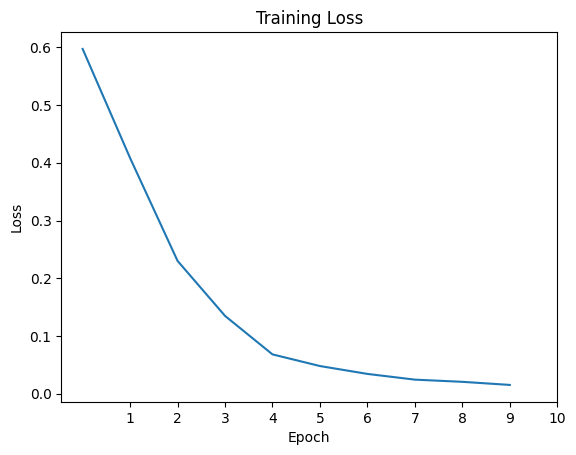

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

In [ ]:

test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [ ]:

f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'long',
                          '1':'short',
                          })

print(report)

F-Score:  0.7788279197110235
Recall:  0.7784449826471249
Precision:  0.7792424247166605
                 long       short  accuracy    macro avg  weighted avg
precision    0.811094    0.747390  0.784468     0.779242      0.784190
recall       0.817221    0.739669  0.784468     0.778445      0.784468
f1-score     0.814146    0.743510  0.784468     0.778828      0.784314
support    662.000000  484.000000  0.784468  1146.000000   1146.000000


In [ ]:
report

,long,short,accuracy,macro avg,weighted avg
precision,0.811094,0.747390,0.784468,0.779242,0.784190
recall,0.817221,0.739669,0.784468,0.778445,0.784468
f1-score,0.814146,0.743510,0.784468,0.778828,0.784314
support,662.000000,484.000000,0.784468,1146.000000,1146.000000
